# Technical Assignment - IKEA DA

Prepared by **Michael Zhang** | 2021 Mar | @AMSTERDAM

## 0. Executive Summary

### Question 1: Propose a segmentation analysis

A natural thought to segment the consumer is to use `clustering analysis`. With a relatively clean data... Seg A, B, C

### Question 3: Key segment(s) to focus to increase sales

Seg A
based on A, B, C reasons
* Increase sales is more of a short-term goal -> with the info I have, either focus on the large seg with potential to upsell (small improvement but big moneytory potential), or niche seg with great %growth potential

### Question 2: Potential data points to improve the analysis

* Unit info: understand if the product is of high unit price (which may not be purchased again in a short term)
* Category info: similar to above; also make it difficult to interpret the clustering
* Transactional info: what does it buy together per order -> basket analysis, frequency analysis, recency (3D of CLV or CV)


### Question 4: Prediction of the value in "HaveChildren" with vitualization

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
# from sklearn-extras
# from sk-learn-extra

In [2]:
## Build a data cleaning package/notebook

## 1. Data Import and Exploration
##### High-level descriptives
* **Sex**: 70% are Male
* **Age**: 35% are 26-35, followed by ~20% 18-25 and 36-45, respectively
* **CityType**: 50%+ from type C cities
* **YearsInCity**: 35% live 1-2 years, followed by 20% 2-3 years (other durations are close too)
* **Professions**: can roughly split into 3 tiers based on the customer count
* **HaveChildren**: 55% Customers do not have children (and 3.5% of them missing this information)

##### Load raw data and convert to proper data type

In [3]:
df = pd.read_csv('RetailCustomerSales.csv',sep = ';', dtype = {'CustomerID':'category',
                                                               'ItemID':'category',
                                                               'Sex':'category',
                                                               'Age':'category',
                                                               'Profession':'category',
                                                               'CityType':'category',
                                                               'YearsInCity':'category',
                                                               'HaveChildren':'str',## to deal witht he NaN
                                                               'ItemCategory1':'str',
                                                               'ItemCategory2':'str',
                                                               'ItemCategory3':'str'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   CustomerID     537577 non-null  category
 1   ItemID         537577 non-null  category
 2   Sex            537577 non-null  category
 3   Age            537577 non-null  category
 4   Profession     537577 non-null  category
 5   CityType       537577 non-null  category
 6   YearsInCity    537577 non-null  category
 7   HaveChildren   517407 non-null  object  
 8   ItemCategory1  537577 non-null  object  
 9   ItemCategory2  370591 non-null  object  
 10  ItemCategory3  164278 non-null  object  
 11  Amount         537577 non-null  int64   
dtypes: category(7), int64(1), object(4)
memory usage: 25.4+ MB


##### Check duplicated rows

In [4]:
df.duplicated().sum()

0

##### Check Null value
Only HaveChildren col has NaN

In [5]:
print(df.isnull().sum())

CustomerID            0
ItemID                0
Sex                   0
Age                   0
Profession            0
CityType              0
YearsInCity           0
HaveChildren      20170
ItemCategory1         0
ItemCategory2    166986
ItemCategory3    373299
Amount                0
dtype: int64


##### Check potential outliers

In [6]:
consumer_spend = df.groupby('CustomerID')['Amount'].sum().sort_values()
consumer_spend = pd.DataFrame(consumer_spend)
consumer_spend.describe()

,Amount
count,5.891000e+03
mean,8.517515e+05
std,9.329978e+05
min,4.410800e+04
25%,2.349140e+05
50%,5.126120e+05
75%,1.099005e+06
max,1.053678e+07


identify the top 3 dots in the box plot and remove them as outlier: > 7M

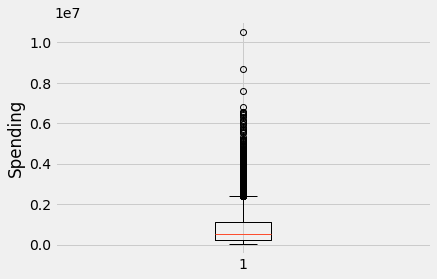

In [7]:
plt.style.use("fivethirtyeight")
plt.boxplot(consumer_spend)
plt.ylabel("Spending")
plt.show()

In [8]:
## Numeric Outlier: set IQR to filter out the outlier
## Ref: https://quantdare.com/isolation-forest-algorithm/
## Ref: https://www.kdnuggets.com/2018/12/four-techniques-outlier-detection.html
## Ref: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

## A bit too agreesive
# IQR = (75%-25%)*1.5(k)
# consumer_spend.loc[consumer_spend['Amount'] >= IQR, 'split'] = 'Outlier'
# consumer_spend.loc[consumer_spend['Amount'] < IQR, 'split'] = 'Inliner' 

# consumer_qtile = consumer_spend.groupby('split')['Amount'].sum()
# consumer_qtile

In [9]:
## From the box plot, try to exclude only the top 3 dot
## Check the top 10 amount -> identify the top dots in the box plot
consumer_spend['Amount'].sort_values(ascending=False).head(10)

CustomerID
1004277    10536783
1001680     8699232
1002909     7577505
1001941     6817493
1000424     6573609
1004448     6565878
1001015     6511302
1003391     6476786
1001181     6387899
1000549     6310604
Name: Amount, dtype: int64

In [10]:
consumer_spend_inliner = consumer_spend['Amount'].sort_values(ascending=False).iloc[3:]
consumer_spend_inliner

CustomerID
1001941    6817493
1000424    6573609
1004448    6565878
1001015    6511302
1003391    6476786
            ...   
1004464      46091
1005944      46070
1005012      45551
1005117      44432
1004991      44108
Name: Amount, Length: 5888, dtype: int64

In [11]:
# len(df['ItemID'].unique())
item_consumer = df.groupby('ItemID')['CustomerID'].nunique().sort_values()
item_consumer.describe()

count    3623.000000
mean      148.378968
std       208.176730
min         1.000000
25%        19.000000
50%        70.000000
75%       192.000000
max      1858.000000
Name: CustomerID, dtype: float64

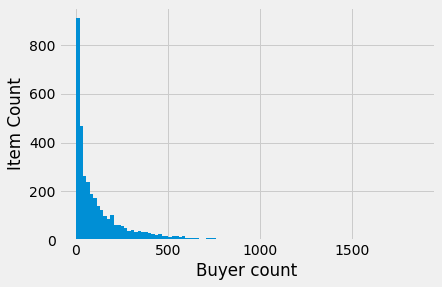

In [12]:
#plot popular product and check distribution
plt.style.use("fivethirtyeight")
plt.hist(item_consumer, bins = 100)
plt.xlabel("Buyer count")
plt.ylabel("Item Count")
plt.show()

In [13]:
# len(df['ItemID'].unique())
item_sales = df.groupby('ItemID')['Amount'].sum().sort_values()
item_sales.describe()

#plot high sales value

count    3.623000e+03
mean     1.384948e+06
std      2.608237e+06
min      4.050000e+02
25%      1.143055e+05
50%      4.352640e+05
75%      1.503716e+06
max      2.753243e+07
Name: Amount, dtype: float64

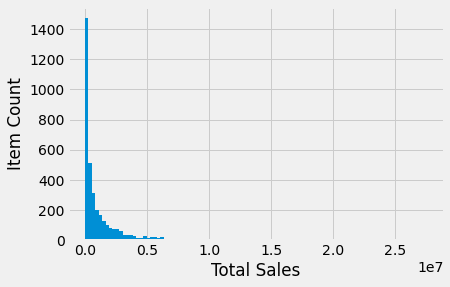

In [14]:
#plot high total sales value and check distribution
plt.style.use("fivethirtyeight")
plt.hist(item_sales, bins = 100)
plt.xlabel("Total Sales")
plt.ylabel("Item Count")
plt.show()

##### Other descriptives

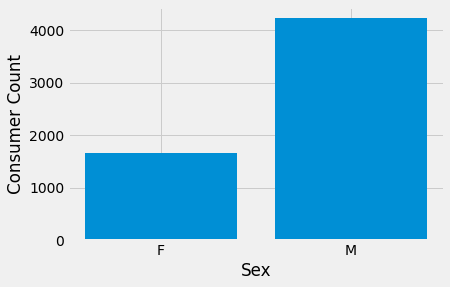

In [15]:
sex = df.groupby('Sex')['CustomerID'].nunique().sort_index()
plt.style.use("fivethirtyeight")
plt.bar(sex.index, sex)
plt.xlabel("Sex")
plt.ylabel("Consumer Count")
plt.show()

In [16]:
round(sex/sex.sum()*100,1)

Sex
F    28.3
M    71.7
Name: CustomerID, dtype: float64

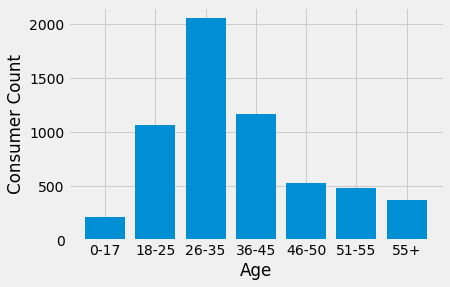

In [17]:
age = df.groupby('Age')['CustomerID'].nunique().sort_index()
plt.style.use("fivethirtyeight")
plt.bar(age.index, age)
plt.xlabel("Age")
plt.ylabel("Consumer Count")
plt.show()

## Main consumer base is aroudn 26-35 YO

In [18]:
round(age/age.sum()*100,1)

Age
0-17      3.7
18-25    18.1
26-35    34.8
36-45    19.8
46-50     9.0
51-55     8.2
55+       6.3
Name: CustomerID, dtype: float64

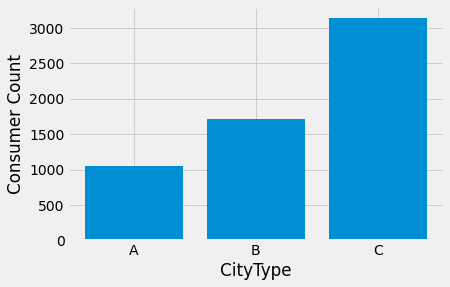

In [19]:
CityType = df.groupby('CityType')['CustomerID'].nunique().sort_index()
plt.style.use("fivethirtyeight")
plt.bar(CityType.index, CityType)
plt.xlabel("CityType")
plt.ylabel("Consumer Count")
plt.show()

In [20]:
round(CityType/CityType.sum()*100,1)

CityType
A    17.7
B    29.0
C    53.3
Name: CustomerID, dtype: float64

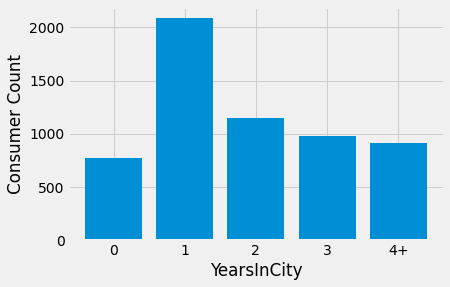

In [21]:
YearsInCity = df.groupby('YearsInCity')['CustomerID'].nunique().sort_index()
plt.style.use("fivethirtyeight")
plt.bar(YearsInCity.index, YearsInCity)
plt.xlabel("YearsInCity")
plt.ylabel("Consumer Count")
plt.show()

In [22]:
round(YearsInCity/YearsInCity.sum()*100,1)

YearsInCity
0     13.1
1     35.4
2     19.4
3     16.6
4+    15.4
Name: CustomerID, dtype: float64

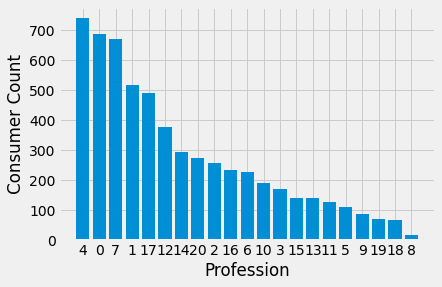

In [23]:
Profession = df.groupby('Profession')['CustomerID'].nunique().sort_values(ascending=False)
plt.style.use("fivethirtyeight")
plt.bar(Profession.index, Profession)
plt.xlabel("Profession")
plt.ylabel("Consumer Count")
plt.show()

In [24]:
round(Profession/Profession.sum()*100,1)

Profession
4     12.6
0     11.7
7     11.4
1      8.8
17     8.3
12     6.4
14     5.0
20     4.6
2      4.3
16     4.0
6      3.9
10     3.3
3      2.9
15     2.4
13     2.4
11     2.2
5      1.9
9      1.5
19     1.2
18     1.1
8      0.3
Name: CustomerID, dtype: float64

Since the missing records account for a small subset (3.6%), consider remove it from the clustering

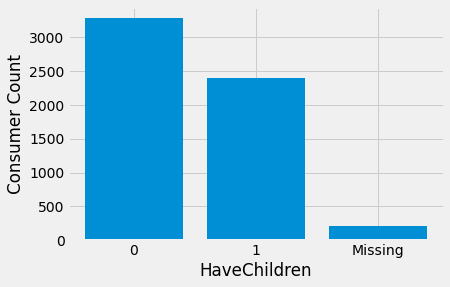

In [25]:
df_c = df.copy()
df_c['HaveChildren'] = df_c['HaveChildren'].fillna('Missing')
HaveChildren = df_c.groupby('HaveChildren')['CustomerID'].nunique().sort_index()
plt.style.use("fivethirtyeight")
plt.bar(HaveChildren.index, HaveChildren)
plt.xlabel("HaveChildren")
plt.ylabel("Consumer Count")
plt.show()

In [26]:
round(HaveChildren/HaveChildren.sum()*100,1)

HaveChildren
0          55.7
1          40.7
Missing     3.6
Name: CustomerID, dtype: float64

###### Check how the category columns structure

In [27]:
df.loc[df['ItemCategory1'] == df['ItemCategory2'],'ItemID'].unique()
## cat start small

[], Categories (0, object): []

##### Convert the category combination to one column
Category 5 and 8 has both very high # of unique items and high sales

In [28]:
df_combo = df.copy()

df_combo['ItemCategory2'].fillna('N', inplace=True)
df_combo['ItemCategory3'].fillna('N', inplace=True)

df_combo['CatCombo'] = df_combo['ItemCategory1']+'_'\
                       +df_combo['ItemCategory2']+'_'\
                       +df_combo['ItemCategory3']

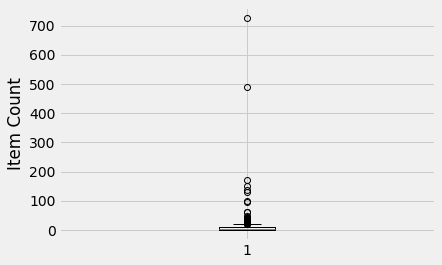

In [29]:
ItemCombo = df_combo.groupby(['CatCombo'])['ItemID'].nunique().sort_values(ascending=False)
plt.style.use("fivethirtyeight")
plt.boxplot(ItemCombo)
plt.ylabel("Item Count")
plt.show()

In [30]:
ItemCombo.head(5)

CatCombo
8_N_N     727
5_N_N     488
11_N_N    171
5_8_N     150
5_14_N    136
Name: ItemID, dtype: int64

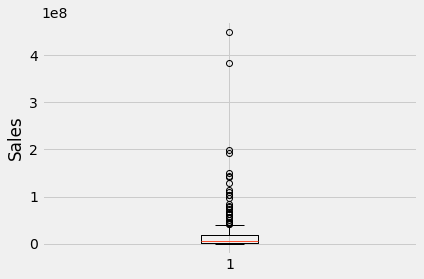

In [31]:
ItemComboSales = df_combo.groupby(['CatCombo'])['Amount'].sum().sort_values(ascending=False)
plt.style.use("fivethirtyeight")
plt.boxplot(ItemComboSales)
plt.ylabel("Sales")
plt.show()

In [32]:
ItemComboSales.head(5)

CatCombo
8_N_N     449437193
5_N_N     383126455
1_16_N    198147606
1_2_15    191990411
5_8_N     149089678
Name: Amount, dtype: int64

## 2. Segmentation (Clustering Analysis)
##### Initial thoughts on data cleaning/preprocessing
* The dataset is clean overall

* Only HaveChildren has `NaN`. Since it accounts for a small subset, may just drop them for clustering (try both dropna and no dropna)

* Potentially remove outliers (customers of exceptionally high total spending), considering we are clustering over CustomerID (try both drop and no drop)  

* Categorical data:
 * **Sex**: code `M` to `1` and `F` to `0`
 * **Age**: replace to mean of upper and lower boundary. Assign `17` to `0-17` and `55` for `55+`
<!--  (as 16 is normally the lowest age we can legally target) -->
 * **CityType**: `A` as `1`, `B` as `2` and `C` as `3`
 * **YearsInCity**: convert to numeric; `4+` as `4`
 * **HaveChildren**: `N` as `-1`, `NaN` as `0` and `Y` as `1`  
 * **Profession**: one-hot encoding to 21 individual features with `1` or `0` values
 * **ItemCategory**: combine all three columns into one `CatCombo`, coded as `ItemCategory1_ItemCategory2_ItemCategory3` (resulting in 235 new categories/category combinations)
* Normalize all features

### 2.1 Data Preparation
#### Obtain demographic labels with `groupby` and save it as `df_demo`

In [ ]:
df_gb = df.copy()
df_gb = df_gb.groupby(['CustomerID','Sex','Age','Profession',\
                       'CityType','YearsInCity','HaveChildren'],dropna=False)['Amount']\
                       .sum().reset_index().set_index('CustomerID')
df_gb = df_gb.rename(columns={'Amount':'TotalSpending'})

Create mapping for `Sex`, `Age`, `CityType`, `YearsInCity` and `HaveChildren`

In [ ]:
replace_map = {'Sex': {'M': 1, 'F': 0},
               'Age': {'0-17': 17, '18-25': 21.5, '26-35': 30.5, '36-45': 40.5,
                       '46-50': 48, '51-55': 53, '55+': 55},
               'CityType': {'A': 1, 'B': 2, 'C': 3},
               'YearsInCity': {'0': 0, '1': 1, '2': 2, '3':3, '4+':4},
               'HaveChildren': {'0': -0.5, '1': 0.5}}

Replace the value with the mapping above

In [ ]:
df_demo = df_gb.copy()
df_demo.replace(replace_map, inplace=True)
df_demo.drop(columns='Profession', inplace=True)

print(df_demo.head())

In [ ]:
df_demo.info()

#### Create one-hot encoding for `Professions` and save it as `df_prof`

In [ ]:
df_prof = df_gb.copy().reset_index().set_index('CustomerID')
df_prof.drop(columns=['Sex','Age','CityType','YearsInCity','HaveChildren','TotalSpending'], inplace=True)
df_prof = pd.get_dummies(df_prof, columns=['Profession'], prefix = ['Prof'])

print(df_prof.head())

#### Combine three `ItemCategory` columns to `CatCombo` and save it as `df_combo`

In [ ]:
df_combo = df.copy()

df_combo['ItemCategory2'].fillna('N', inplace=True)
df_combo['ItemCategory3'].fillna('N', inplace=True)

df_combo['CatCombo'] = df_combo['ItemCategory1']+'_'\
                       +df_combo['ItemCategory2']+'_'\
                       +df_combo['ItemCategory3']

print(df_combo.sort_values(['CatCombo']).head())

#### Pivot the `CatCombo` column to wide format, resulting in each row respresenting a unique `CustomerID` and each columns contains its spending in each category combo

In [ ]:
df_combo = pd.pivot_table(df_combo, values=['Amount'], index=['CustomerID'],\
                          columns=['CatCombo'], aggfunc=np.sum, fill_value=0)\
                          .reset_index().set_index('CustomerID').droplevel(0, axis=1)

df_combo.info()

In [ ]:
print(df_combo.head())

#### Complie all the features

In [ ]:
df_compile = df_demo.join([df_prof, df_combo])
print(df_compile.head(5))

In [ ]:
df_compile.info()

#### Drop missing value in `HaveChildren`

In [ ]:
df_dropna = df_compile.dropna(subset=['HaveChildren'])
df_dropna.info()

#### Drop outliers (`TotalSpending` >= 7M)

In [ ]:
df_inliner = df_dropna.loc[consumer_spend_inliner.index,:]

### 2.2 K-mean Clustering

In [187]:
## K-means
## Ref: https://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means
## Ref: https://realpython.com/k-means-clustering-python/

## PAM (Partitioning Around Medoids)
## Ref: https://towardsdatascience.com/clustering-datasets-having-both-numerical-and-categorical-variables-ed91cdca0677

## Categorical data
## Ref: https://www.datacamp.com/community/tutorials/categorical-data
## Ref: https://pbpython.com/categorical-encoding.html  
## Ref: https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
## Ref: https://stats.stackexchange.com/questions/393331/is-one-hot-encoding-and-standardization-of-data-equivalent-to-gowers-distance
## Ref: https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/#:~:text=A%20one%20hot%20encoding%20is,is%20marked%20with%20a%201.
## Ref: https://datascience.stackexchange.com/questions/22/k-means-clustering-for-mixed-numeric-and-categorical-data


##### Convert dataframe to array

In [188]:
# features_full = df_full[['Sex','Age','CityType','YearsInCity','HaveChildren','TotalSpending']].to_numpy()
# features_full

##### Scale the features

In [189]:
# scaler = MinMaxScaler()
# scaled_features_full = scaler.fit_transform(features_full)
# scaled_features_full

##### Set the parameter of K-means clustering

In [190]:
# kmeans = KMeans(
#     init="k-means++",
#     n_clusters=4,
#     n_init=50,
#     max_iter=500,
#     random_state=42
# )

In [191]:
# kmeans.fit(scaled_features_full)

##### Result & Evaluation

In [192]:
# # The lowest SSE value
# kmeans.inertia_

In [193]:
# # Final locations of the centroid
# kmeans.cluster_centers_

In [194]:
# # The number of iterations required to converge
# kmeans.n_iter_

In [195]:
# kmeans.labels_[:5]

##### SSE

In [196]:
# kmeans_kwargs = {
#     "init": "k-means++",
#     "n_init": 10,
#     "max_iter": 300,
#     "random_state": 42,
# }

# # A list holds the SSE values for each k
# sse = []
# for k in range(1, 11):
#     kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
#     kmeans.fit(scaled_features_full)
#     sse.append(kmeans.inertia_)

In [197]:
# ## Determine the elbow from plot
# plt.style.use("fivethirtyeight")
# plt.plot(range(1, 11), sse)
# plt.xticks(range(1, 11))
# plt.xlabel("Number of Clusters")
# plt.ylabel("SSE")
# plt.show()

In [198]:
# ## Determine the elbow programmatically
# kl = KneeLocator(
#     range(1, 11), sse, curve="convex", direction="decreasing"
# )

# kl.elbow

#### Evaluation - silhouette coefficients

In [199]:
# # A list holds the silhouette coefficients for each k
# silhouette_coefficients = []

# # Notice you start at 2 clusters for silhouette coefficient
# for k in range(2, 11):
#     kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
#     kmeans.fit(scaled_features_full)
#     score = silhouette_score(scaled_features_full, kmeans.labels_)
#     silhouette_coefficients.append(score)

In [200]:
# ## Determine the max(sc) from plot
# plt.style.use("fivethirtyeight")
# plt.plot(range(2, 11), silhouette_coefficients)
# plt.xticks(range(2, 11))
# plt.xlabel("Number of Clusters")
# plt.ylabel("Silhouette Coefficient")
# plt.show()

#### Build the pipeline

In [201]:
def KMeanClusterM(n, data):
    
    preprocessor = Pipeline(
        [
            ("scaler", MinMaxScaler())
        ]
    )

    clusterer = Pipeline(
       [
           (
               "kmeans",
               KMeans(
                   n_clusters=n,
                   init="k-means++",
                   n_init=50,
                   max_iter=500,
                   random_state=99,
               ),
           ),
       ]
    )

    pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clusterer", clusterer)
        ]
    )

    pipe.fit(data)
    
    preprocessed_data = pipe["preprocessor"].transform(data)

    predicted_labels = pipe["clusterer"]["kmeans"].labels_
    
    return predicted_labels, silhouette_score(preprocessed_data, predicted_labels)

In [202]:
def KMeanClusterS(n, data):
    
    preprocessor = Pipeline(
        [
            ("scaler", StandardScaler())
        ]
    )

    clusterer = Pipeline(
       [
           (
               "kmeans",
               KMeans(
                   n_clusters=n,
                   init="k-means++",
                   n_init=50,
                   max_iter=500,
                   random_state=99,
               ),
           ),
       ]
    )

    pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clusterer", clusterer)
        ]
    )

    pipe.fit(data)
    
    preprocessed_data = pipe["preprocessor"].transform(data)

    predicted_labels = pipe["clusterer"]["kmeans"].labels_
    
    return predicted_labels, silhouette_score(preprocessed_data, predicted_labels)

##### Use the complete data

In [203]:
features_full = df_full.iloc[:,:6].to_numpy()
features_full

array([[ 0.000000e+00,  1.600000e+01,  1.000000e+00,  2.000000e+00,
        -5.000000e-01,  3.334810e+05],
       [ 1.000000e+00,  5.500000e+01,  3.000000e+00,  4.000000e+00,
        -5.000000e-01,  8.103530e+05],
       [ 1.000000e+00,  3.050000e+01,  1.000000e+00,  3.000000e+00,
        -5.000000e-01,  3.416350e+05],
       ...,
       [ 0.000000e+00,  5.500000e+01,  3.000000e+00,  2.000000e+00,
        -5.000000e-01,  8.085900e+04],
       [ 0.000000e+00,  4.800000e+01,  2.000000e+00,  4.000000e+00,
         5.000000e-01,  5.545040e+05],
       [ 1.000000e+00,  3.050000e+01,  2.000000e+00,  2.000000e+00,
        -5.000000e-01,  1.562615e+06]])

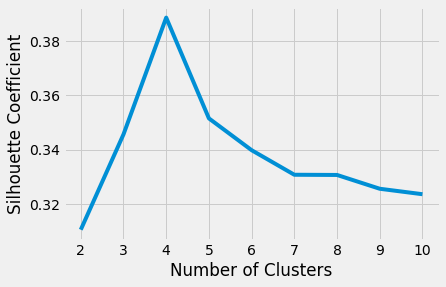

In [204]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients1M = []
predicted_labels1M = []

for k in range(2, 11):
    pred_labels, sc = KMeanClusterM(k, features_full)
    silhouette_coefficients.append(sc)
    predicted_labels1M.append(pred_labels)
    
## Determine the max(sc) from plot
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients1M)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

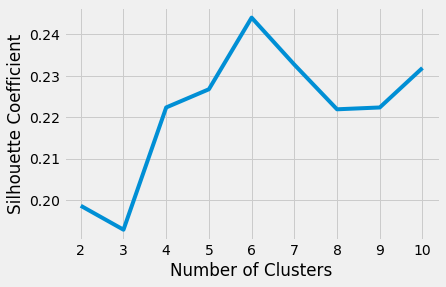

In [205]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients1S = []
predicted_labels1S = []

for k in range(2, 11):
    pred_labels, sc = KMeanClusterS(k, features_full)
    silhouette_coefficients1S.append(sc)
    predicted_labels1S.append(pred_labels)
    
## Determine the max(sc) from plot
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients1S)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

##### Use the non-NA data (of "HaveChildren")

In [206]:
features_dropna = df_dropna.iloc[:,:6].to_numpy()
features_dropna

array([[ 0.000000e+00,  1.600000e+01,  1.000000e+00,  2.000000e+00,
        -5.000000e-01,  3.334810e+05],
       [ 1.000000e+00,  5.500000e+01,  3.000000e+00,  4.000000e+00,
        -5.000000e-01,  8.103530e+05],
       [ 1.000000e+00,  3.050000e+01,  1.000000e+00,  3.000000e+00,
        -5.000000e-01,  3.416350e+05],
       ...,
       [ 0.000000e+00,  5.500000e+01,  3.000000e+00,  2.000000e+00,
        -5.000000e-01,  8.085900e+04],
       [ 0.000000e+00,  4.800000e+01,  2.000000e+00,  4.000000e+00,
         5.000000e-01,  5.545040e+05],
       [ 1.000000e+00,  3.050000e+01,  2.000000e+00,  2.000000e+00,
        -5.000000e-01,  1.562615e+06]])

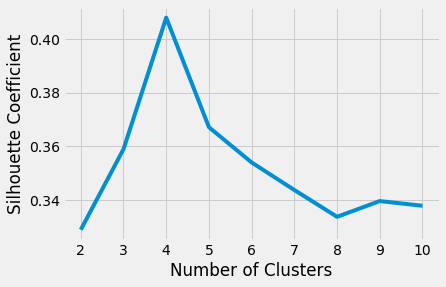

In [207]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients2 = []
predicted_labels2 = []

for k in range(2, 11):
    pred_labels, sc = KMeanClusterM(k, features_dropna)
    silhouette_coefficients2.append(sc)
    predicted_labels2.append(pred_labels)
    
## Determine the max(sc) from plot
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients2)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

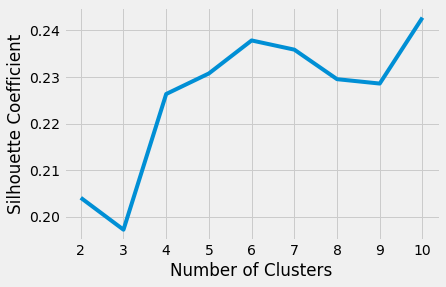

In [208]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients2 = []
predicted_labels2 = []

for k in range(2, 11):
    pred_labels, sc = KMeanClusterS(k, features_dropna)
    silhouette_coefficients2.append(sc)
    predicted_labels2.append(pred_labels)
    
## Determine the max(sc) from plot
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients2)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### 2.3 Descriptives of each cluster

##### Assigning labels to each row

In [219]:
df_clustered = df_gb.copy()
df_clustered['cluster'] = predicted_labels[4]

for col in ['Sex','Age','Profession','CityType','YearsInCity','HaveChildren','cluster']:
    df_clustered[col] = df_clustered[col].astype('category')

df_clustered = df_clustered.join(df_combo).reset_index()

In [220]:
## customer counts in each cluster
df_clustered.groupby('cluster')['CustomerID'].count()

cluster
0     593
1     693
2    1358
3     899
4    1783
5     565
Name: CustomerID, dtype: int64

##### Descriptive by each cluster
* sex split
* age distribution
* CityType
* YearsInCity
* HaveChildren
* TotalSpending

In [221]:
## customer counts in each cluster
df_clustered.groupby(['cluster','Sex'])['CustomerID'].count()/len(df_clustered)

cluster  Sex
0        F      0.000000
         M      0.100662
1        F      0.117637
         M      0.000000
2        F      0.000000
         M      0.230521
3        F      0.152606
         M      0.000000
4        F      0.000000
         M      0.302665
5        F      0.012562
         M      0.083347
Name: CustomerID, dtype: float64

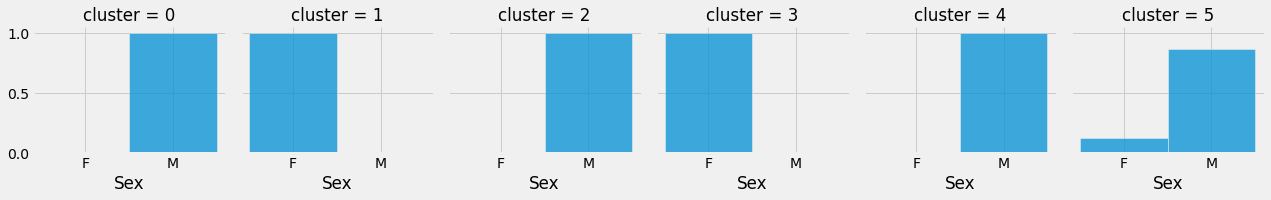

In [248]:
g0 = sns.FacetGrid(df_clustered, col="cluster")
g0.map(sns.histplot,'Sex',stat="density", common_norm=False)
# g1.fig

In [223]:
## customer counts in each cluster
df_clustered.groupby(['cluster','CityType'])['CustomerID'].count()/len(df_clustered)

cluster  CityType
0        A           0.099304
         B           0.001358
         C           0.000000
1        A           0.015108
         B           0.034459
         C           0.068070
2        A           0.000000
         B           0.063826
         C           0.166695
3        A           0.028348
         B           0.044984
         C           0.079273
4        A           0.000000
         B           0.083857
         C           0.218808
5        A           0.034629
         B           0.061280
         C           0.000000
Name: CustomerID, dtype: float64

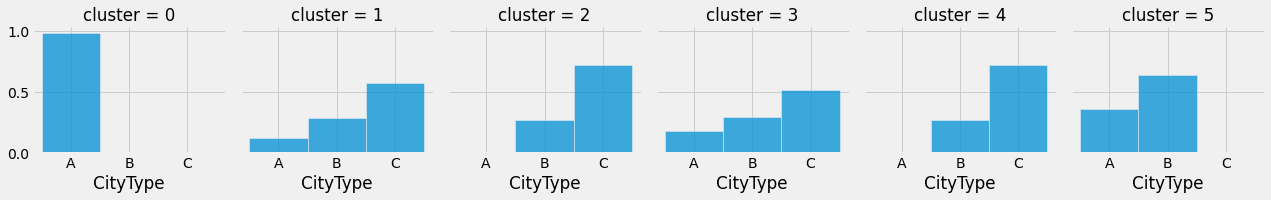

In [247]:
g1 = sns.FacetGrid(df_clustered, col="cluster")
g1.map(sns.histplot,'CityType',stat="density", common_norm=False)
# g1.fig

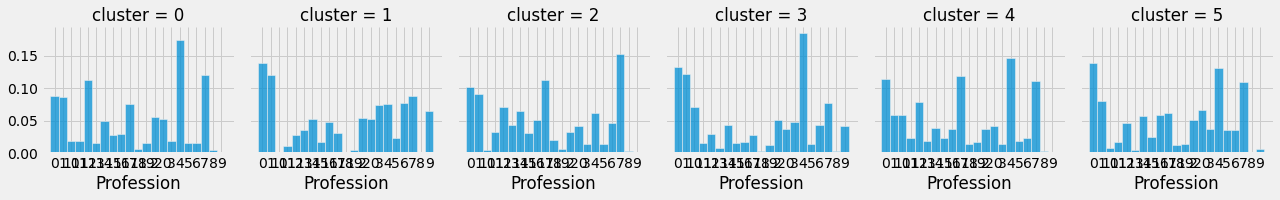

In [246]:
## Difficult to interpret - optentially related to income level/education etc.
g2 = sns.FacetGrid(df_clustered, col="cluster")
g2.map(sns.histplot,'Profession',stat="density", common_norm=False)
# g2.fig

In [226]:
# ## customer aounts in each cluster
# df_clustered.groupby(['cluster'])['Age'].mean()

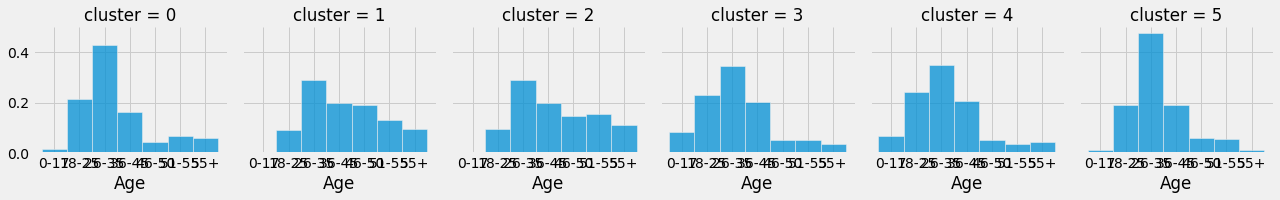

In [245]:
g3 = sns.FacetGrid(df_clustered, col="cluster")
g3.map(sns.histplot,'Age',stat="density", common_norm=False)
# g3.fig

In [236]:
## customer counts in each cluster
df_clustered.groupby(['cluster','YearsInCity'])['YearsInCity'].count()

cluster  YearsInCity
0        0               74
         1              233
         2               90
         3               99
         4+              97
1        0               90
         1              259
         2              135
         3              116
         4+              93
2        0              161
         1              496
         2              278
         3              211
         4+             212
3        0              116
         1              314
         2              184
         3              155
         4+             130
4        0              248
         1              595
         2              358
         3              293
         4+             289
5        0               83
         1              189
         2              100
         3              105
         4+              88
Name: YearsInCity, dtype: int64

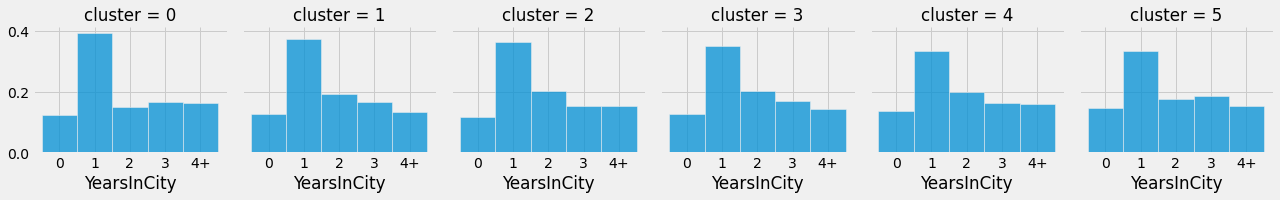

In [249]:
g4 = sns.FacetGrid(df_clustered, col="cluster")
g4.map(sns.histplot,'YearsInCity',stat="density", common_norm=False)
# g3.fig

In [230]:
## customer counts in each cluster
df_clustered.groupby(['cluster','HaveChildren'])['CustomerID'].count()/len(df_clustered)

cluster  HaveChildren
0        0               0.058055
         1               0.037345
1        0               0.000000
         1               0.112545
2        0               0.000000
         1               0.223731
3        0               0.147174
         1               0.000000
4        0               0.293499
         1               0.000000
5        0               0.058055
         1               0.033611
Name: CustomerID, dtype: float64

ConversionError: Failed to convert value(s) to axis units: 2         0
4         1
14      NaN
18        0
19        0
       ... 
5870      1
5874      1
5878      0
5882      0
5884      0
Name: x, Length: 593, dtype: category
Categories (2, object): ['0', '1']

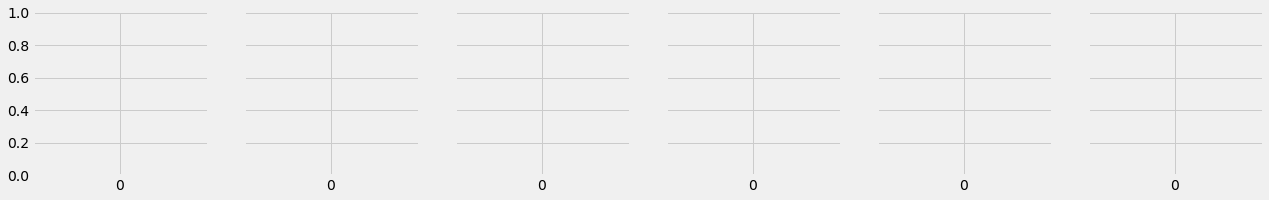

In [237]:
g5 = sns.FacetGrid(df_clustered, col="cluster")
g5.map(sns.histplot,'HaveChildren')
# g3.fig

In [238]:
df_clustered.groupby(['cluster'])['TotalSpending'].mean()

cluster
0    7.118089e+05
1    5.619352e+05
2    6.243762e+05
3    5.808918e+05
4    6.076993e+05
5    3.101756e+06
Name: TotalSpending, dtype: float64

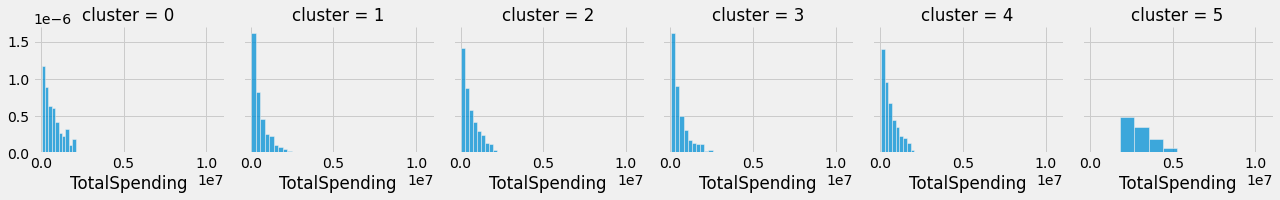

In [253]:
g6 = sns.FacetGrid(df_clustered, col="cluster")
g6.map(sns.histplot,'TotalSpending',stat="density", common_norm=False, bins=10)
# g3.fig